In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from mpl_toolkits.axes_grid1 import make_axes_locatable
from data_analysis import Dataset

import warnings
warnings.filterwarnings("ignore")
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

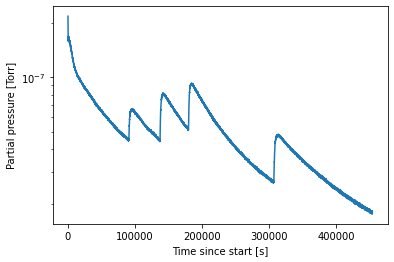

In [2]:
run_label = '20210707' ## Change this to look at different runs
d = Dataset(run_label=run_label, gases=['O2', 'CO2'])
d.GetData()
d.FindPeaks()
d.GetRanges()
d.PlotSingleGas('CO2')

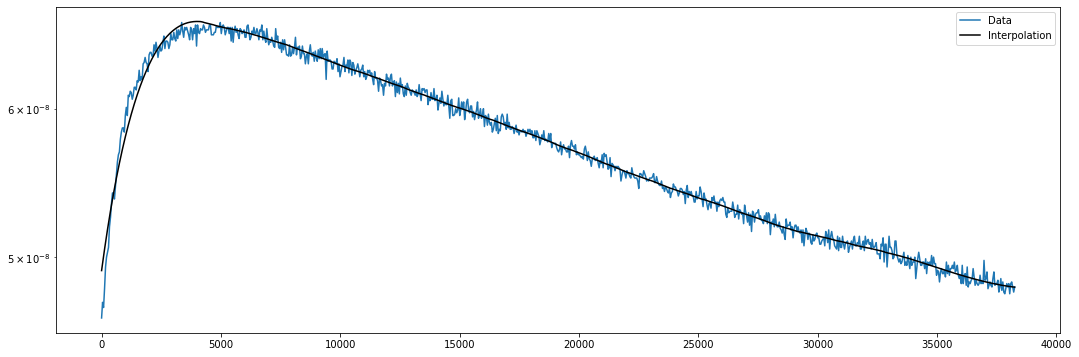

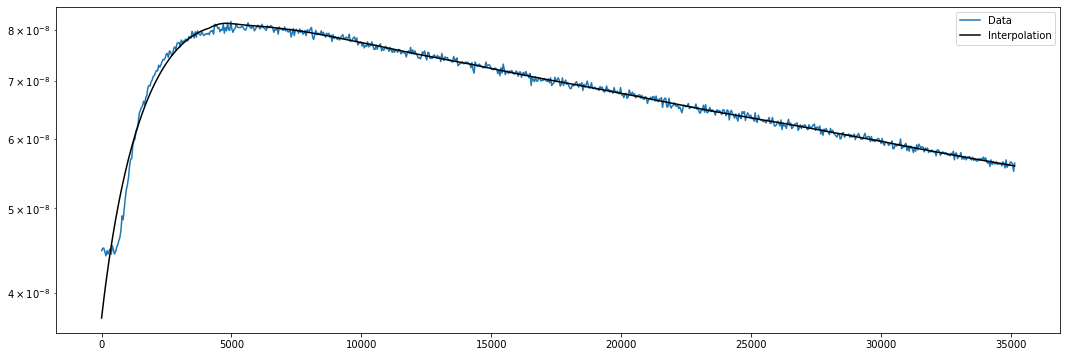

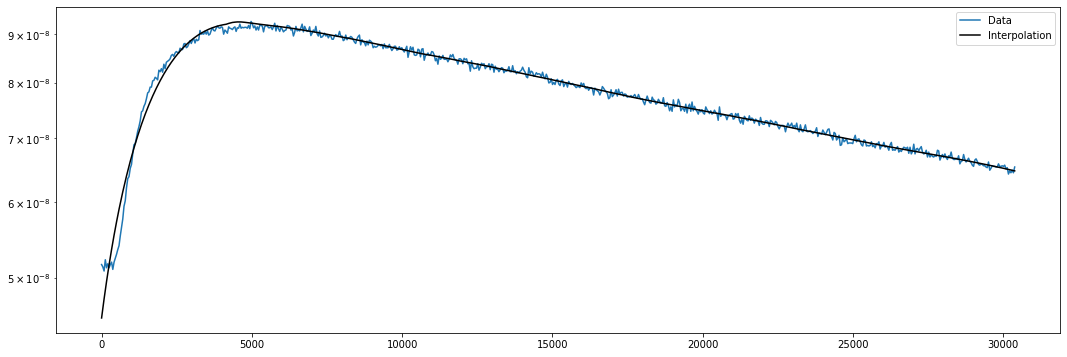

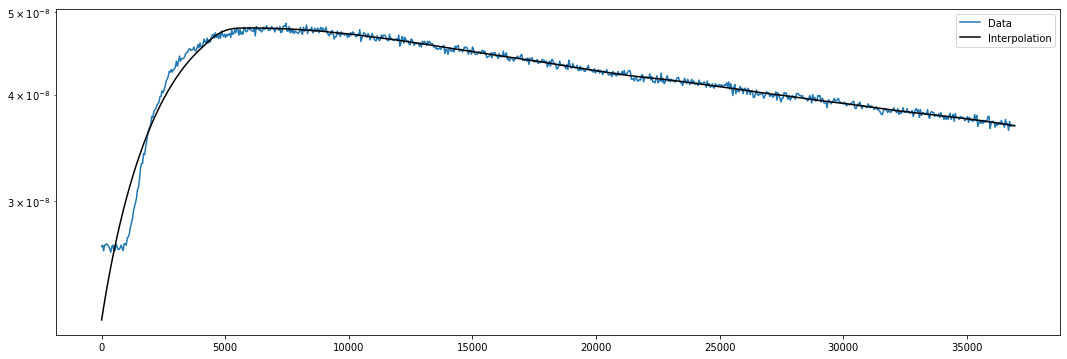

In [3]:
#for CO2 (O2 has been ignored), 
#loop through each fitrange, which is just each "mountain region" (aka. peak),
#and print one plot for each peak corresponding (as you'll specify later) to a particular temperature
#and follow the "if-elif-else" guidelines for the fitrange ("mountain region"); that is, if for [0]-[1], elif for the last
# ([3]), and else for any other fit range (here, [2]), such that
#these guidelines obtain the x-axis data (time), y-axis data (pressure), and temperature_1 data for each peak 

#the black interpolation line to smooth out the noise

#Recall
#def fitfunction(self,tT,a,b,c):
        #factor = np.exp(-1.0*b/tT[1])
        #return a * factor * np.exp(-1.0*c*tT[0]*factor)
    
#Curve_fit: 
    #scipy.optimize.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(- inf, inf), method=None, jac=None, **kwargs) 
    #your x-axis data is [xdata, temp1] because the function 'fitfunction' has those two arguments
    #popt, pcov => the former gives the unknown coefficients in f that give an f-value that is most similar to ydata (least residual)
    #*popt passes a list of arguments to the function called here

a_range = np.arange(0, 10000, 1000) 
b_range = np.arange(0, 10000, 1000)

for i,gas in enumerate(d.gases):
    if gas =='O2':
        continue
       
    for j, fitrange in enumerate(d.range[gas]): 
        fig, axes = plt.subplots(nrows=1, figsize=(18,6))
        
        if j < 2:
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:fitrange[1]] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:fitrange[1]]
            temp1 = np.array(d.data[gas]['ch1_lerp'])[fitrange[0]:fitrange[1]]
        elif j < (len(d.range[gas]) - 1) :
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]
            temp1 = np.array(d.data[gas]['ch1_lerp'])[fitrange[0]:int(fitrange[0]+(fitrange[1]-fitrange[0])/4)]    
        else:
            time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
            xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['exp_time'])-1-fitrange[0])/4)] - time_offset
            ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['pressure'])-1-fitrange[0])/4)]
            temp1 = np.array(d.data[gas]['ch1_lerp'])[fitrange[0]:int(fitrange[0]+
                                                                      (len(d.data[gas]['ch1_lerp'])-1-fitrange[0])/4)]
          
        # interpolation to smooth out the noise
        xx = np.linspace(xdata.min(),xdata.max(), len(xdata))
        itp = interp1d(xdata,ydata, kind='linear')
        window_size, poly_order = 201, 3
        yy_sg = savgol_filter(itp(xx), window_size, poly_order)
        
        # plotting the axes
        axes.plot(xdata, ydata, label='Data')
        axes.plot(xx,yy_sg, label='Interpolation', c='k')
        axes.set_yscale('log')
        
                      
        plt.legend()
        plt.show() #Plots the DATA, which does not necessarily following the double exponential
        
                
        
       



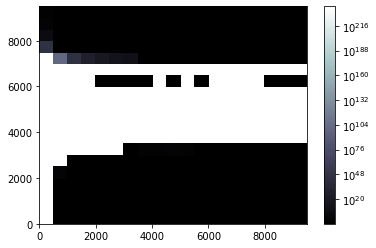

In [13]:
import matplotlib.colors as colors

a_range = np.arange(0, 10000, 500) 
b_range = np.arange(0, 10000, 500)

A_x, B_x = np.meshgrid(a_range, b_range)
params_chi = [(a,b) for a in a_range for b in b_range]


Chi = []  
for x in a_range:
    chi_b = []
    for y in b_range:
        popt1,pcov1 = curve_fit(d.fitfunction, [xdata,temp1], ydata, p0 = [x, y, 28950000])
        fit1 = d.fitfunction([xdata,temp1], *popt1)
        chi_data1 = np.sum((fit1 - ydata)**2 / fit1)
        if chi_data1 == np.inf:
            chi_data1 = 0         
        chi_b.append(chi_data1)
    Chi.append(chi_b)
    



min_chi = np.min(Chi)
Chi = np.array(Chi)

plt.figure()
im1 = plt.pcolormesh(A_x, B_x, Chi.T-min_chi, cmap = 'bone', norm=colors.LogNorm()) 
plt.colorbar()

plt.show()

In [14]:
print(Chi)

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 9.64969987e+237 2.74210686e+046
  1.75951988e+005 6.43548513e-004 3.05933900e-006 2.93393647e-008]
 [1.36788867e-008 1.36788851e-008 1.36788868e-008 1.36788862e-008
  5.87167589e-004 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.22131890e+100 1.36788859e-008
  1.36788848e-008 1.36788856e-008 1.36788862e-008 1.36788841e-008]
 [1.36788862e-008 1.36788853e-008 1.36788861e-008 1.36788837e-008
  1.36788873e-008 1.36788862e-008 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 3.63765392e+045 1.36788844e-008
  1.36788836e-008 1.36788842e-008 1.36788850e-008 1.36788837e-008]
 [1.367